# Installing libraries

In [1]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: brotli
    Found existing installation: Brotli 1.0.9
    Uninstalling Brotli-1.0.9:
      Successfully uninstalled Brotli-1.0.9


In [2]:
import numpy as np
import pandas as pd

import os
import py7zr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence


import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
CUR_DIR = "/kaggle/input/kkbox-music-recommendation-challenge/"

# Exploratory data analysis

In [3]:
for f in ["train", "songs", "song_extra_info", "members"]:
    with py7zr.SevenZipFile(os.path.join(CUR_DIR, f + ".csv.7z"), mode='r') as z:
        z.extractall()
    
train = pd.read_csv("train.csv").rename({"msno": "user_id"},axis=1)
members = pd.read_csv("members.csv", 
                      parse_dates=['registration_init_time','expiration_date']
                     ).rename({"bd": "age", "msno" : "user_id"}, axis=1)
songs_info = pd.read_csv("song_extra_info.csv")
songs = pd.read_csv("songs.csv").merge(songs_info, on="song_id")

train.head(2)

,user_id,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1


## Songs exploration

In [4]:
songs.head(2)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN


### Cleaning the data from NaNs and outlayers

In [ ]:
songs.isnull().sum()

In [ ]:
#let's remove the song with the unknown language:
songs = songs[songs.language.notnull()]

In [ ]:
ax = sns.barplot(x=songs.language.value_counts().sort_index().index,
                 y=songs.language.value_counts().sort_index().values)
ax.set_title("Histplot of songs languages")
ax.set_xlabel("Language")
plt.show()

#the distribution of songs languages is extremely far from uniform, so we have
#some kind of imbalance. but it would be illogical to merge different
#categories into one in order to balance the categories, so we will
#leave this column like this

In [ ]:
#let us suppose that the songs with unknown composer have composer = artist,
#because many artists write both: texts and instrumental for their songs.
#the same can begeneralization supposed and for a lyricist.
songs.loc[songs.composer.isnull(), "composer"] = songs[songs.composer.isnull()].artist_name
songs.loc[songs.lyricist.isnull(), "lyricist"] = songs[songs.lyricist.isnull()].artist_name

In [ ]:
songs.loc[songs.name.isnull(), "name"] = "unknown"

In [ ]:
ax = sns.histplot(songs.song_length.value_counts().sort_index().index)
ax.set_title("Histplot of songs length")
ax.set_xlabel("Songs length, ms")
plt.show()

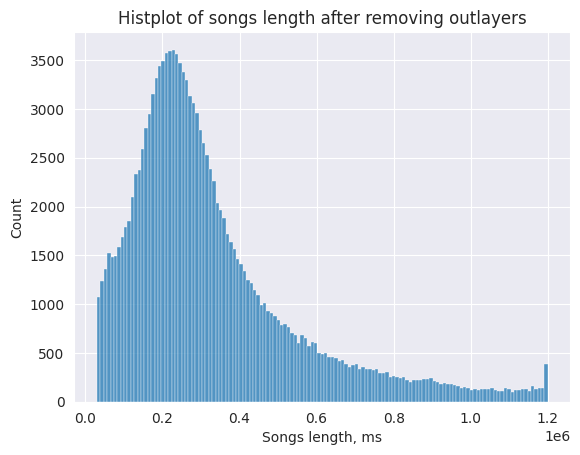

In [4]:
#let's remove the outlayers (songs that have length more than 20 minutes
#and less than 30 seconds):
songs = songs[(songs.song_length >= 30 * 1000) & (songs.song_length <= 20 * 60 * 1000)] 
ax = sns.histplot(songs.song_length.value_counts().sort_index().index)
ax.set_title("Histplot of songs length after removing outlayers")
ax.set_xlabel("Songs length, ms")
plt.show()

### Filling the missing values in genre_ids

In [ ]:
#let's fill for every song the missing values in genre_ids with the most frequent 
#genre of the artist of the song (if it's known)

artists_ = songs[songs.genre_ids.isnull()].artist_name.value_counts()
artists_no_genre = list(artists_[artists_ > 1].index) #the artists for whom
#we don't know a genre of at least one song (we don't consider the artists
#with only one song because we can't know the most frequent genre for them)

In [ ]:
def fill_missing_value(x):
    # fill missing values with the most frequent values
    return x.value_counts().sort_values(ascending=False).index[0]

c = 0
for artist in tqdm(artists_no_genre):
    if np.all(songs[songs.artist_name == artist].genre_ids.isnull()):
        c += 1
        continue
    artist_songs = songs.loc[songs.artist_name == artist, :]
    value = fill_missing_value(artist_songs[artist_songs.genre_ids.notnull()]["genre_ids"])
    songs.loc[(songs.artist_name == artist) & songs.genre_ids.isnull(),"genre_ids"] = value
    

In [4]:
songs = pd.read_csv("/kaggle/input/preprocessed-songs/processed_songs.csv", index_col=0)
songs["genre_ids"].fillna("unknown", inplace=True)

In [26]:
songs.isnull().sum()

song_id             0
song_length         0
genre_ids           0
artist_name         0
composer            0
lyricist            0
language            0
name                0
isrc           134425
dtype: int64

## Members exploration

In [ ]:
members.head(2)

## Cleaning data from NaNs and outlayers

In [ ]:
members.isnull().sum()

In [ ]:
ax = sns.barplot(x=members.registered_via.value_counts().index,
                 y=members.registered_via.value_counts().values)
ax.set_title("Histplot of registration ways")
ax.set_xlabel("Registration way")
plt.show()

In [ ]:
#let's remove the outlayers:
members = members[(members.registered_via != 13) & (members.registered_via != 16)]

In [ ]:
ax = sns.barplot(x=members.age.value_counts().index,
                 y=members.age.value_counts().values)
ax.set_title("Histplot of ages")
ax.set_xlabel("Age")
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

In [ ]:
#let's remove the outlayers that belong to (0, 10] \cup [58, 140)
members = members[((members.age == 0) | (members.age > 10)) & (members.age < 58)]
ax = sns.barplot(x=members.age.value_counts().index,
                 y=members.age.value_counts().values)
ax.set_title("Histplot of ages")
ax.set_xlabel("Age")
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

## Transforming dates

In [ ]:
#let's transform data to features ['day', 'month', 'year']
def data_to_features(df, col, type_="reg"):
    df[type_ + "_day"] = df[col].dt.day
    df[type_ + "_month"] = df[col].dt.month
    df[type_ + "_year"] = df[col].dt.year
    return df.drop(col, axis=1)

members = data_to_features(members, "registration_init_time")
members = data_to_features(members, "expiration_date", type_="exp")
members.head(2)

## Filling the missing values

In [ ]:
#nulls are the values that are missed. let's try to restore them using CatBoostRegressor
X_train_age = members[members['age'] != 0].copy() 
y_train_age = X_train_age['age']
X_train_age.drop(['user_id' ,'age','gender'],axis=1, inplace=True)

X_test_age =  members[members['age'] == 0].copy() 
X_test_age.drop(['user_id' ,'age','gender'],axis=1, inplace=True)

In [ ]:
model = CatBoostRegressor(verbose=0)
cv_params = {'iterations': [800, 900],
            'learning_rate': np.linspace(0.01, 0.1, num=10),
            'depth': [2, 3, 4]}

grid = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=4, verbose=1, n_jobs=2)
grid.fit(X_train_age.values, y_train_age.values.ravel())

In [ ]:
print("The best value of parameters: {0}".format(grid.best_params_))
print('Best model score: {0}'.format(abs(grid.best_score_)))

In [ ]:
best_model_regr = CatBoostRegressor(**grid.best_params_, verbose=0)
best_model_regr.fit(X_train_age, y_train_age)
age_preds = best_model_regr.predict(X_test_age).round(0)
members.loc[members['age'] == 0, 'age'] = age_preds

In [ ]:
ax = sns.barplot(x=members.age.value_counts().index,
                 y=members.age.value_counts().values)
ax.set_title("Histplot of ages")
ax.set_xlabel("Age")
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

In [ ]:
members.loc[members.gender.isnull(), "gender"] = "unknown"

ax = sns.barplot(x=members.gender.value_counts().index,
                 y=members.gender.value_counts().values)
ax.set_title("Histplot of gender")
ax.set_xlabel("Gender")
# plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

In [ ]:
#let's again try to fill the missing values with CatBoostClassifier:
X_train_gender = members[members['gender'] != "unknown"].copy() 
X_train_gender["gender"] = X_train_gender["gender"] == "male"
y_train_gender = X_train_gender['gender']
X_train_gender.drop(['user_id' ,'age', "gender"],axis=1 , inplace=True)

X_test_gender =  members[members['gender'] == "unknown"].copy() 
X_test_gender.drop(['user_id' ,'age', "gender"],axis=1 , inplace=True)

In [ ]:
model = CatBoostClassifier(verbose=0)
cv_params = {'iterations': [400, 500, 600],
            'learning_rate': [0.009, 0.03, 0.09],
            'depth': [4, 6, 8]}

grid = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=4, verbose=1, n_jobs=2)
grid.fit(X_train_gender.values, y_train_gender.values.ravel())

In [ ]:
print("The best value of parameters: {0}".format(grid.best_params_))
print('Best model score: {0}'.format(abs(grid.best_score_)))

In [ ]:
best_model_clf = CatBoostClassifier(**grid.best_params_, verbose=0)
best_model_clf.fit(X_train_gender, y_train_gender)
gender_preds = best_model_clf.predict(X_test_gender).round(0)
members.loc[members['gender'] == "unknown", "gender"] = gender_preds

In [5]:
members.loc[members.gender == 1, "gender"] = "male"
members.loc[members.gender == 0, "gender"] = "female"

In [5]:
members = pd.read_csv("/kaggle/input/preprocessed-members/preprocessed_members.csv", index_col=0)

# Feature engineering

## Feature addition

In [7]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    return np.nan
    

def isrc_to_country(isrc):
    if type(isrc) == str:
        return isrc[:2]
    return np.nan

    
#extracting the year and the country of the artist of the song from isrc        
songs['song_year'] = songs['isrc'].apply(isrc_to_year)
songs['song_country'] = songs['isrc'].apply(isrc_to_country)

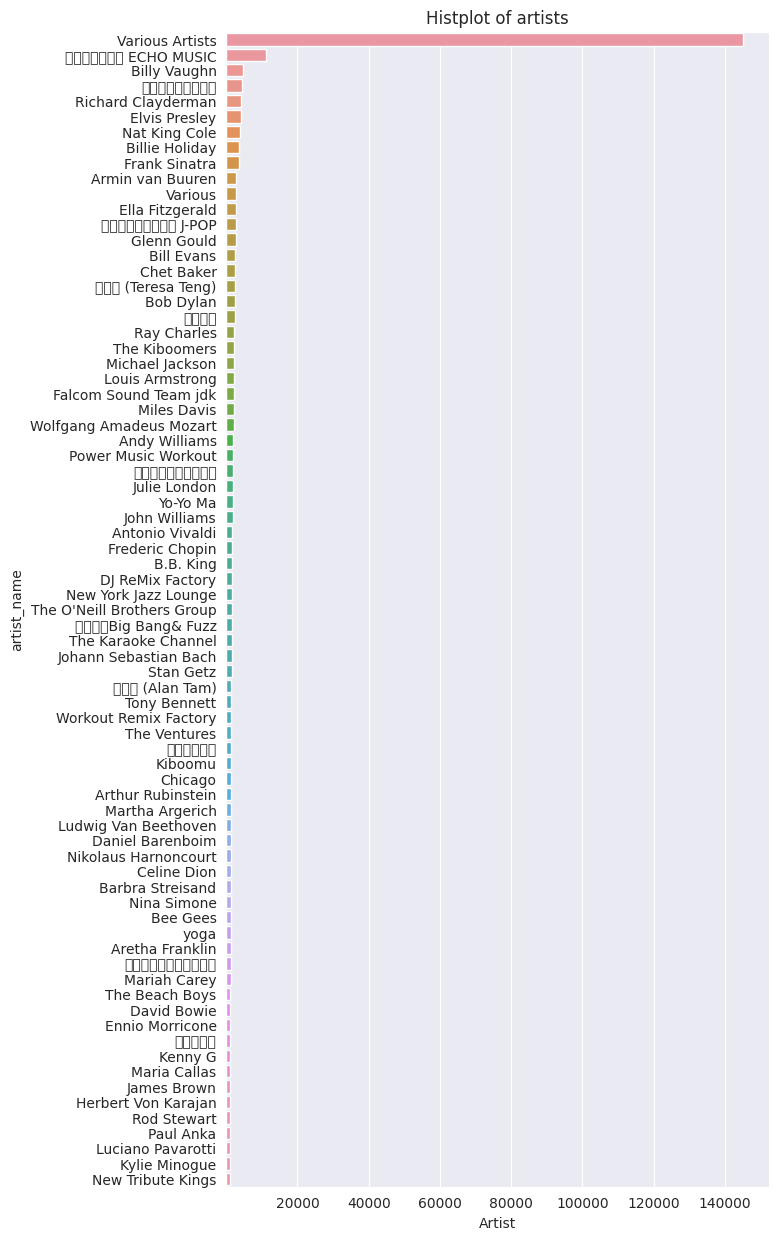

In [7]:
#let's look on our variables' distribution to see whether we can add some new features:
fig, ax = plt.subplots(figsize=(7, 15))
sns.barplot(x=songs.artist_name.value_counts().iloc[:75].values,
            y=songs.artist_name.value_counts().iloc[:75].index)
ax.set_title("Histplot of artists")
ax.set_xlabel("Artist")
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

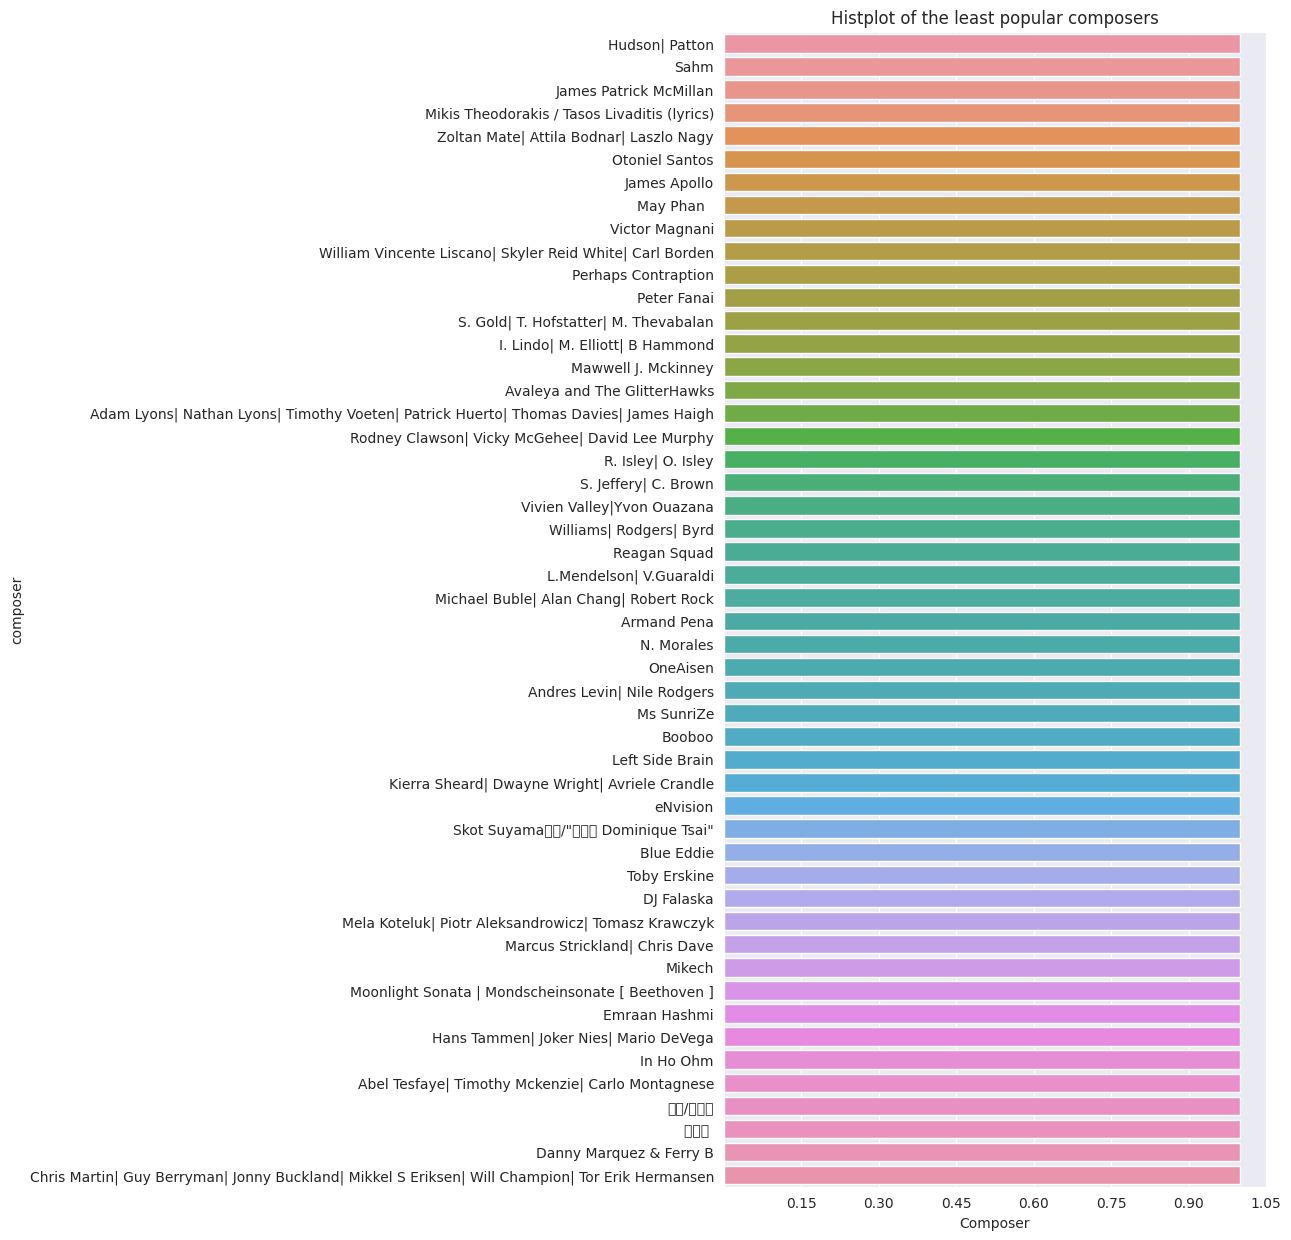

In [8]:
fig, ax = plt.subplots(figsize=(7, 15))
sns.barplot(x=songs.composer.value_counts().iloc[-50:].values,
            y=songs.composer.value_counts().iloc[-50:].index)
ax.set_title("Histplot of the least popular composers")
ax.set_xlabel("Composer")
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

In [8]:
#we see that some composers have just one song in the dataset, so
#let's join them into one category in order to reduce categories count
composers_count = (songs.composer.value_counts() == 1).sum()
songs.loc[songs.composer.isin(songs.composer.value_counts().iloc[-composers_count:].index),
          "composer"] = "least_pop"

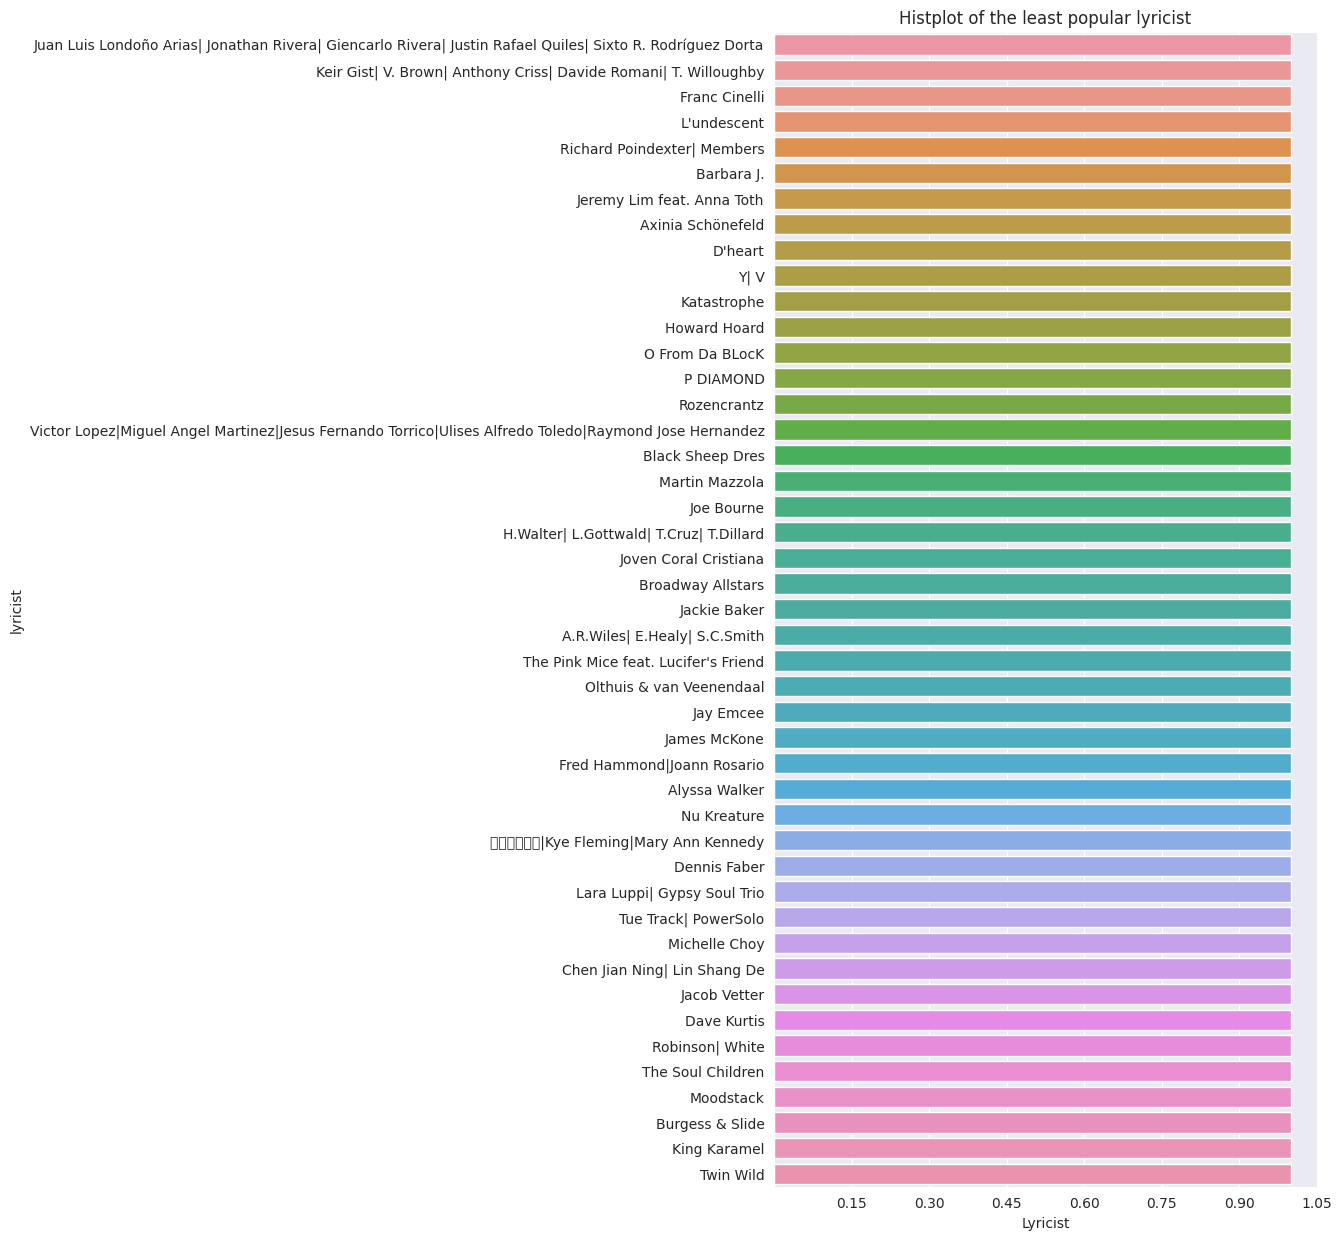

In [30]:
fig, ax = plt.subplots(figsize=(7, 15))
sns.barplot(x=songs.lyricist.value_counts().iloc[-60:-15].values,
            y=songs.lyricist.value_counts().iloc[-60:-15].index)
ax.set_title("Histplot of the least popular lyricist")
ax.set_xlabel("Lyricist")
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

In [9]:
#we see that some lyricists have just one song in the dataset, so
#let's join them into one category in order to reduce categories count
lyricists_count = (songs.lyricist.value_counts() == 1).sum()
songs.loc[songs.lyricist.isin(songs.lyricist.value_counts().iloc[-lyricists_count:].index),
          "lyricist"] = "least_pop"

## Feature merging and transformation

In [10]:
train = train.merge(songs, on="song_id").merge(members, on="user_id")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306189 entries, 0 to 7306188
Data columns (total 26 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   song_id             object 
 2   source_system_tab   object 
 3   source_screen_name  object 
 4   source_type         object 
 5   target              int64  
 6   song_length         int64  
 7   genre_ids           object 
 8   artist_name         object 
 9   composer            object 
 10  lyricist            object 
 11  language            float64
 12  name                object 
 13  isrc                object 
 14  song_year           float64
 15  song_country        object 
 16  city                int64  
 17  age                 int64  
 18  gender              object 
 19  registered_via      int64  
 20  reg_day             int64  
 21  reg_month           int64  
 22  reg_year            int64  
 23  exp_day             int64  
 24  exp_month           int6

In [11]:
train.drop(["isrc", "name"], axis=1, inplace=True)

In [12]:
y_data = train["target"]
X_data = train.fillna("0")

In [13]:
#let's change the initial letter values of song_id and user_id by
#their indexes in the tables
X_data = X_data.merge(songs.reset_index()[["index", "song_id"]], 
                      on="song_id").drop("song_id", axis=1).rename({"index": "song_id"}, axis=1)

X_data = X_data.merge(members.reset_index()[["index", "user_id"]], 
                      on="user_id").drop("user_id", axis=1).rename({"index": "user_id"}, axis=1)

In [14]:
ct = ColumnTransformer([
    ("gender", OrdinalEncoder(), ["gender"]),
    ("artist_name", OrdinalEncoder(), ["artist_name"]),
    ("composer", OrdinalEncoder(), ["composer"]),
    ("lyricist", OrdinalEncoder(), ["lyricist"]),
    ("song_country", OrdinalEncoder(), ["song_country"]),
    ("src_system_tab", OrdinalEncoder(), ["source_system_tab"]),
    ("src_screen_name", OrdinalEncoder(), ["source_screen_name"]),
    ("src_type", OrdinalEncoder(), ["source_type"]),
    ("genre_ids", OrdinalEncoder(), ["genre_ids"]),
    ],
    remainder="passthrough", 
    sparse_threshold=0.3, 
    verbose=True)

X_data_tr = ct.fit_transform(X_data)

[ColumnTransformer] ....... (1 of 10) Processing gender, total=   2.0s
[ColumnTransformer] .. (2 of 10) Processing artist_name, total=   3.2s
[ColumnTransformer] ..... (3 of 10) Processing composer, total=   3.3s
[ColumnTransformer] ..... (4 of 10) Processing lyricist, total=   3.1s
[ColumnTransformer] . (5 of 10) Processing song_country, total=   2.6s
[ColumnTransformer]  (6 of 10) Processing src_system_tab, total=   2.3s
[ColumnTransformer]  (7 of 10) Processing src_screen_name, total=   2.2s
[ColumnTransformer] ..... (8 of 10) Processing src_type, total=   2.2s
[ColumnTransformer] .... (9 of 10) Processing genre_ids, total=   2.2s
[ColumnTransformer] ... (10 of 10) Processing remainder, total=   0.0s


In [15]:
cols_tr = ["gender", "artist_name", "composer", 
           "lyricist", "song_country", "source_system_tab", "source_screen_name", 
           "source_type", "genre_ids", "target", "song_length", "language", "song_year",
           "city", "age", "registered_via", "reg_day", "reg_month", "reg_year",
           "exp_day", "exp_month", "exp_year", "song_id", "user_id"]

X_data_tr = pd.DataFrame(X_data_tr, columns=cols_tr)

## Feature selection

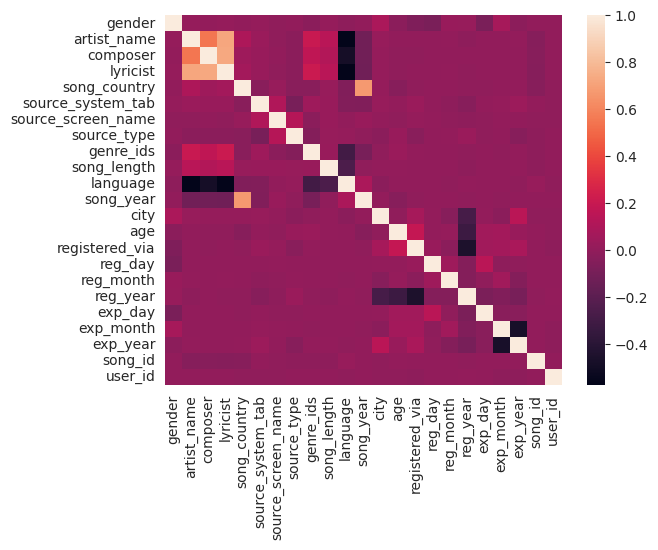

In [15]:
#let's see if there's a linear relationship between the features
sns.heatmap(X_data_tr.corr())
plt.show()

#we can notice that features artist_name and lyricist, artist_name and composer
#have correlation coefficient approximately 0.7, but 
#1) it's logical, because in many cases they are the same people
#2) this value indicates just a moderate correlation
#the rest of values are relatively small

Note that there's no point to calculate pearson's correlation coefficient between each variable and the target because it indicates only linear relationship,
that we probably don't have in our data (otherwise the task would be too easy).

For the same reasons it's useless to try Lasso or Ridge regression, because they again can indicate only linear (or polynomial, if we power the features), that is
too easy.

## Dataset creation

In [16]:
train_set = X_data_tr[["user_id", "song_id"]].groupby("user_id").apply(
    lambda x: list(x.song_id[-150:])).reset_index().rename(
    {0: "song_id"}, axis=1).merge(
    X_data_tr[["user_id", "target"]].groupby("user_id").apply(
    lambda x: list(x.target[-150:])).reset_index().rename(
    {0: "target"}, axis=1), on="user_id")
train_set.head(2)

,user_id,song_id,target
0,0,"[1297207, 526612, 2230537, 121753, 333075, 191...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,"[68379, 330299, 410600, 139311, 1659935, 15928...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [17]:
assert len(train_set.iloc[0][1]) == 150

# Using ALS

In [19]:
X_train4, X_valid4 = train_test_split(train_set, test_size=0.1, random_state=42, shuffle=False)

In [22]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 60.8 MB/s eta 0:00:0000:0100:01


In [24]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100)

In [29]:
from scipy import sparse

user_items = sparse.coo_matrix(
    (
        (
            X_train4.user_id,
            X_train4.song_id
        )
    )
).tocsr()

TypeError: invalid input format

In [27]:
np.random.seed(42)
model.fit(X_train4.drop("target", axis=1))

AttributeError: 'DataFrame' object has no attribute 'tocsr'

# Trying BERT4Rec

In [18]:
from sklearn.model_selection import train_test_split

class SongDataset(Dataset):
    def __init__(self, dataset, n_items):
        super().__init__()
        self.ds = dataset
        self.n_items = n_items

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds.iloc[idx]
        seq_input = [x + 1 for x in row["song_id"]]
        targets = row["target"]
        return (seq_input, targets)

n_items = len(songs)
train_dataset = SongDataset(dataset=X_train4, n_items=n_items)
valid_dataset = SongDataset(dataset=X_valid4, n_items=n_items)

In [21]:
#let's create dataloaders:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(torch.tensor(src_sample))
        tgt_batch.append(torch.tensor(tgt_sample))
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)
    return torch.tensor(src_batch), torch.tensor(tgt_batch)

PAD_IDX = 0

train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=2, collate_fn=collate_fn)

# Using ALS to get the predictions

# Using BERT4Rec to get the predictions

In [22]:
# class PositionalEmbedding(nn.Module):
#     def __init__(self, d_model, max_len, dropout = 0.1):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
#         pe = torch.zeros(1, max_len, d_model)
        
#         pe[0, :, 0::2] = torch.sin(position * div_term)
#         pe[0, :, 1::2] = torch.cos(position * div_term)
#         self.pos_embedding = pe

#     def forward(self, x):
#         x = x + self.pos_embedding[:, :x.shape[1]].to(device)
#         return self.dropout(x)

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.pos_embedding = pe

    def forward(self, x):
        x = x + self.pos_embedding[:x.shape[1]].to(device)
        return self.dropout(x)


class DecoderBlock(nn.Module):
    def __init__(self, emb_dim, ff_dim, n_heads=8, p=0.15):
        super().__init__()
        self.attention = nn.MultiheadAttention(emb_dim, n_heads, kdim=emb_dim, vdim=emb_dim, batch_first=True)
        self.dropout1 = nn.Dropout(p)

        self.feedforward = nn.Sequential(nn.Linear(emb_dim, ff_dim),
                                         nn.ReLU(),
                                         nn.Linear(ff_dim, emb_dim))
        self.dropout2 = nn.Dropout(p)
        
    def forward(self, x, mask):
        x_clone = x.detach().clone().to(device)
        x, _ = self.attention(x, x, x, attn_mask=mask)
        x = self.dropout1(x)
        x += x_clone

        x1 = x.clone().to(device)
        x = self.feedforward(x)
        x = self.dropout2(x)
        return x1 + x
    
device = torch.device('cpu')

In [23]:
class BERT4Rec(nn.Module):
    def __init__(self, n_items, bs=256):
        super().__init__()
        self.ITEM_SEQ = 'seq_i'
        self.ITEM_SEQ_LEN = 'seq_len'
        self.max_seq_length = 150
        self.hidden_size = 64  # same as embedding_size
        self.inner_size = 64 # the dimensionality in feed-forward layer

        self.p = 0.3
        self.n_items = n_items #vocab_size

        self.item_embedding = nn.Embedding(self.n_items + 1, self.hidden_size)  # mask token add 1
        self.position_embedding = PositionalEmbedding(self.hidden_size, self.max_seq_length + 1)  # add mask_token at the last
        

        self.layer_norm = nn.LayerNorm(self.hidden_size)
        self.dropout = nn.Dropout(self.p)

        self.block1 = DecoderBlock(self.hidden_size, self.inner_size)
        self.block2 = DecoderBlock(self.hidden_size, self.inner_size)
        self.block3 = DecoderBlock(self.hidden_size, self.inner_size)
        self.linear = nn.Linear(self.hidden_size, self.max_seq_length)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(self.max_seq_length, 1)

        # parameters initialization   
#         self.apply(self._init_weights)
        
        
    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
            
    def create_mask(self, sz):
        mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask    
    
    
    def forward(self, item_seq):
        item_emb = self.position_embedding(self.item_embedding(item_seq))
        
        input_emb = self.layer_norm(item_emb)
        input_emb = self.dropout(input_emb)
        
        mask = self.create_mask(min(item_seq.shape[1], item_emb.shape[1]))
        x = self.block1(input_emb, mask)
        x = self.block2(x, mask)
        x = self.block3(x, mask)

        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        return x.squeeze()

In [25]:
def train_epoch(model, loader, criterion, optimizer, desc):
    model.train()
    train_loss = 0
    for src_seq, tgt_seq in tqdm(loader, desc=desc):
        src_seq = src_seq[:200].to(device)
        tgt_seq = tgt_seq[:200].to(device)
        
        outs = model(src_seq)
        print(outs.shape, tgt_seq.shape)
        loss = criterion(outs, tgt_seq.to(torch.float32))
        print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(loader)


@torch.no_grad()
def val_epoch(model, loader, criterion, desc):
    model.eval()
    val_loss = 0
    for src_seq, tgt_seq in tqdm(loader, desc=desc):
        src_seq = src_seq.to(device)
        tgt_seq = tgt_seq.to(device)

        outs = model(src_seq)
        loss = criterion(outs, tgt_seq.to(torch.float32))

        val_loss += loss.item()
    return val_loss / len(loader)


def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    prev_val_loss = 1e6
    patience = 0
    for epoch in range(1, n_epochs + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer,
                             f'Training {epoch}/{n_epochs}')

        val_loss = val_epoch(model, val_loader, criterion,
                        f'Validating {epoch}/{n_epochs}')
        if val_loss < prev_val_loss:
            print("Best model ever")
            torch.save(model.state_dict(), f"/content/tr{epoch}.pth")
            prev_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= 8:
                break
        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")



#'cuda' if torch.cuda.is_available() else 

In [27]:
device = torch.device("cpu")

In [28]:
model = BERT4Rec(n_items=n_items+1).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
# lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [29]:
train(model, train_loader, valid_loader, criterion, optimizer, 1)

Training 1/1:   0%|          | 0/13744 [00:00<?, ?it/s]

torch.Size([2, 150]) torch.Size([2, 150])


Training 1/1:   0%|          | 1/13744 [00:00<3:29:47,  1.09it/s]

tensor(303.5682, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 23]) torch.Size([2, 23])
tensor(17.0958, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 8/13744 [00:01<22:15, 10.28it/s]  

torch.Size([2, 3]) torch.Size([2, 3])
tensor(-0., device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 117]) torch.Size([2, 117])
tensor(19.3378, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(171.0151, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(237.3459, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(207.7191, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(235.0376, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(252.7709, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 12/13744 [00:01<15:03, 15.20it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(73.9203, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 40]) torch.Size([2, 40])
tensor(62.0624, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 59]) torch.Size([2, 59])
tensor(58.6313, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 32]) torch.Size([2, 32])
tensor(21.8492, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(223.5334, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(173.4363, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(179.3275, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 20/13744 [00:01<09:56, 23.02it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(255.3674, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(333.7366, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(389.8829, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(97.1599, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(385.6306, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(250.8800, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 16]) torch.Size([2, 16])
tensor(22.5402, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 28/13744 [00:01<08:08, 28.05it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(182.4754, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(465.2852, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(530.5785, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 14]) torch.Size([2, 14])
tensor(20.1703, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(121.9367, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(508.9933, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 12]) torch.Size([2, 12])
tensor(2.4672, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 36/13744 [00:01<07:23, 30.90it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(196.1147, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(148.6576, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(439.4954, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(305.3197, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 31]) torch.Size([2, 31])
tensor(39.1359, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(304.8174, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 39]) torch.Size([2, 39])
tensor(30.1176, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 40/13744 [00:02<07:10, 31.82it/s]

torch.Size([2, 13]) torch.Size([2, 13])
tensor(5.0967, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 18]) torch.Size([2, 18])
tensor(16.0710, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(259.5575, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(60.2839, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(183.5207, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(179.4994, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(190.3695, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 48/13744 [00:02<07:01, 32.50it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(69.5945, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(252.3352, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(313.8219, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(309.9133, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(198.4087, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 9]) torch.Size([2, 9])
tensor(-0., device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(312.2439, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 56/13744 [00:02<06:52, 33.22it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(424.2541, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 53]) torch.Size([2, 53])
tensor(38.5722, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 3]) torch.Size([2, 3])
tensor(0.5165, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(213.8950, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(253.8190, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(334.3282, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(470.9178, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 64/13744 [00:02<06:47, 33.60it/s]

torch.Size([2, 13]) torch.Size([2, 13])
tensor(1.8814, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(160.0471, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(149.9353, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(225.6199, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(170.3505, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(229.9519, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(308.0866, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   0%|          | 68/13744 [00:02<06:46, 33.61it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(124.7236, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(368.6630, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(82.8046, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 59]) torch.Size([2, 59])
tensor(75.1466, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(495.2214, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(350.2502, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(342.2068, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 76/13744 [00:03<06:47, 33.54it/s]

torch.Size([2, 75]) torch.Size([2, 75])
tensor(77.7630, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 142]) torch.Size([2, 142])
tensor(188.1776, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(128.1109, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 128]) torch.Size([2, 128])
tensor(160.3070, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(187.0096, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(288.0814, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(336.1432, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 84/13744 [00:03<06:46, 33.60it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(136.3522, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(316.8395, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 40]) torch.Size([2, 40])
tensor(65.4973, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(136.1419, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(474.7455, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(147.6054, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 26]) torch.Size([2, 26])
tensor(8.0196, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 92/13744 [00:03<06:44, 33.79it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(156.0348, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(143.4672, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 21]) torch.Size([2, 21])
tensor(39.7192, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(212.3621, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(290.4316, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(328.7403, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(466.1372, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 96/13744 [00:03<06:43, 33.80it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(213.5035, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(328.1448, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 132]) torch.Size([2, 132])
tensor(150.4774, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(297.9503, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(84.8603, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(310.9024, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(338.3454, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 104/13744 [00:03<06:43, 33.81it/s]

torch.Size([2, 99]) torch.Size([2, 99])
tensor(113.4779, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(220.6565, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(226.7216, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 89]) torch.Size([2, 89])
tensor(176.2927, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(308.0229, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(428.2376, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(205.7845, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 112/13744 [00:04<06:42, 33.83it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(81.3696, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(248.5420, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(178.0733, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 92]) torch.Size([2, 92])
tensor(47.2821, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(508.6305, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(159.6211, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(379.0320, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 120/13744 [00:04<06:41, 33.93it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(285.9574, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(269.2660, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(227.7337, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(105.2357, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(67.4821, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(108.0439, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(218.5434, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 124/13744 [00:04<06:40, 33.99it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(130.8461, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 45]) torch.Size([2, 45])
tensor(38.8733, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(337.8846, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(380.7119, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 114]) torch.Size([2, 114])
tensor(217.4687, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(197.9703, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 44]) torch.Size([2, 44])
tensor(18.4638, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 132/13744 [00:04<06:43, 33.74it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(148.6293, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(281.5292, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(59.8628, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(514.1122, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 64]) torch.Size([2, 64])
tensor(17.7538, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(305.5789, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(385.6783, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 140/13744 [00:05<06:42, 33.82it/s]

torch.Size([2, 5]) torch.Size([2, 5])
tensor(-0., device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(380.4270, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(170.4454, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(146.1221, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 21]) torch.Size([2, 21])
tensor(17.6972, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(107.6277, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(401.9412, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 148/13744 [00:05<06:40, 33.93it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(195.6856, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(207.5744, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 134]) torch.Size([2, 134])
tensor(145.9683, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(403.3834, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 22]) torch.Size([2, 22])
tensor(3.1246, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 4]) torch.Size([2, 4])
tensor(0.3505, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(119.0304, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 152/13744 [00:05<06:41, 33.86it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(173.9668, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(210.5748, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 124]) torch.Size([2, 124])
tensor(256.2454, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(248.2767, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(387.9856, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(337.9224, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(331.2515, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 160/13744 [00:05<06:39, 33.97it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(154.6681, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 22]) torch.Size([2, 22])
tensor(3.9809, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 45]) torch.Size([2, 45])
tensor(21.0232, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(184.9239, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(247.7766, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 48]) torch.Size([2, 48])
tensor(44.6700, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(229.8956, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|          | 168/13744 [00:05<06:40, 33.89it/s]

torch.Size([2, 37]) torch.Size([2, 37])
tensor(36.5614, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 142]) torch.Size([2, 142])
tensor(131.6207, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(220.1831, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 110]) torch.Size([2, 110])
tensor(157.2231, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(79.9862, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(298.5460, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(268.1235, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|▏         | 176/13744 [00:06<06:40, 33.87it/s]

torch.Size([2, 15]) torch.Size([2, 15])
tensor(4.5426, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(470.0400, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(103.5953, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 72]) torch.Size([2, 72])
tensor(67.7670, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(414.4416, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 33]) torch.Size([2, 33])
tensor(31.5783, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(160.4881, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|▏         | 180/13744 [00:06<06:41, 33.82it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(344.5923, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 124]) torch.Size([2, 124])
tensor(89.0565, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 96]) torch.Size([2, 96])
tensor(217.7098, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(212.7508, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 11]) torch.Size([2, 11])
tensor(0.0332, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(175.3830, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(122.9478, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|▏         | 188/13744 [00:06<06:41, 33.80it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(345.3982, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(520.1245, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 48]) torch.Size([2, 48])
tensor(37.3342, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 49]) torch.Size([2, 49])
tensor(68.1669, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(184.8535, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(167.2765, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(599.2860, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|▏         | 196/13744 [00:06<06:48, 33.18it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(258.0632, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(336.5484, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(328.4256, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 111]) torch.Size([2, 111])
tensor(112.4722, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(330.4901, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(139.4187, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 83]) torch.Size([2, 83])
tensor(145.8862, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   1%|▏         | 204/13744 [00:06<06:43, 33.57it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(94.9779, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(334.9621, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(82.8772, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(89.2214, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(288.1472, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 61]) torch.Size([2, 61])
tensor(37.7377, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(175.8479, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   2%|▏         | 208/13744 [00:07<06:41, 33.69it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(110.5541, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(318.7790, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 68]) torch.Size([2, 68])
tensor(134.9477, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(143.2099, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 64]) torch.Size([2, 64])
tensor(68.6703, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(358.3099, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(234.8310, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   2%|▏         | 216/13744 [00:07<06:39, 33.85it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(428.4259, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(305.1353, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(202.4820, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(192.9927, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 104]) torch.Size([2, 104])
tensor(126.3200, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(316.3047, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 141]) torch.Size([2, 141])
tensor(120.9351, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   2%|▏         | 224/13744 [00:07<06:38, 33.91it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(119.4668, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(213.6287, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(98.4399, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 46]) torch.Size([2, 46])
tensor(17.7870, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(350.9598, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(226.5550, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 91]) torch.Size([2, 91])
tensor(92.3647, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   2%|▏         | 232/13744 [00:07<06:37, 33.96it/s]

torch.Size([2, 52]) torch.Size([2, 52])
tensor(80.1756, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(303.4640, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(365.5453, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 49]) torch.Size([2, 49])
tensor(76.6634, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(390.8827, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(288.3640, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(340.7527, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   2%|▏         | 236/13744 [00:07<06:38, 33.89it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(212.5911, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(124.4561, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(360.0047, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(197.4948, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 84]) torch.Size([2, 84])
tensor(143.9465, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(331.5286, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(227.7486, device='cuda:0', grad_fn=<DivBackward1>)


Training 1/1:   2%|▏         | 244/13744 [00:08<06:38, 33.84it/s]

torch.Size([2, 150]) torch.Size([2, 150])
tensor(185.3357, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(285.3714, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 108]) torch.Size([2, 108])
tensor(190.2686, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(383.3392, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 150]) torch.Size([2, 150])
tensor(180.9229, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 144]) torch.Size([2, 144])
tensor(159.6274, device='cuda:0', grad_fn=<DivBackward1>)
torch.Size([2, 131]) torch.Size([2, 131])
tensor(233.4930, device='cuda:0', grad_fn=<DivBackward1>)


/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [124,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [124,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [124,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [124,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [124,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [124,0,0], thread: [101,0,0] Assertio

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [57]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"